# **Image Depth Estimation Using Window-based Matching**

## **Download Dataset**

In [1]:
# Aloe
!gdown --id 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 10.9MB/s]


In [2]:
!unzip Aloe_images.zip

Archive:  Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


## **Install Algorithms**

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [4]:
def l1_distance(x, y):
    return abs(x - y)

def l2_distance(x, y):
    return (x - y) ** 2

In [5]:
def cosine_similarity(x, y):
    numerator = np.dot(x, y)
    denominator = np.linalg.norm(x) * np.linalg.norm(y)

    return numerator / denominator

In [6]:
def window_based_matching_l1(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255 * 9

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            # Find j where cost has minimum value
            disparity = 0
            cost_min  = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = l1_distance(
                                int(left[y + v, x + u]), int(right[y + v, (x + u) - j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite(f'window_based_l1.png', depth)
        cv2.imwrite(f'window_based_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth

In [7]:
def window_based_matching_l2(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255 ** 2

    for y in range(kernel_half, height-kernel_half):
        for x in range(kernel_half, width-kernel_half):

            # Find j where cost has minimum value
            disparity = 0
            cost_min  = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = l2_distance(int(left[y + v, x + u]),  int(right[y + v, (x + u) - j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite(f'window_based_l2.png', depth)
        cv2.imwrite(f'window_based_l2_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth

In [8]:
def window_based_matching_cosine_similarity(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    kernel_half = int((kernel_size - 1) / 2)
    scale = 3

    for y in range(kernel_half, height-kernel_half):
        for x in range(kernel_half, width-kernel_half):
            # Find j where cost has minimum value
            disparity = 0
            cost_optimal  = -1

            for j in range(disparity_range):
                d = x - j
                cost = -1
                if (d - kernel_half) > 0:
                    wp = left[(y-kernel_half):(y+kernel_half)+1, (x-kernel_half):(x+kernel_half)+1]
                    wqd = right[(y-kernel_half):(y+kernel_half)+1, (d-kernel_half):(d+kernel_half)+1]

                    wp_flattened = wp.flatten()
                    wqd_flattened = wqd.flatten()

                    cost = cosine_similarity(wp_flattened, wqd_flattened)

                if cost > cost_optimal:
                    cost_optimal = cost
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite('window_based_cosine_similarity.png', depth)
        cv2.imwrite('window_based_cosine_similarity_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth

## **Evaluate Algorithms**

### **Problem 2**

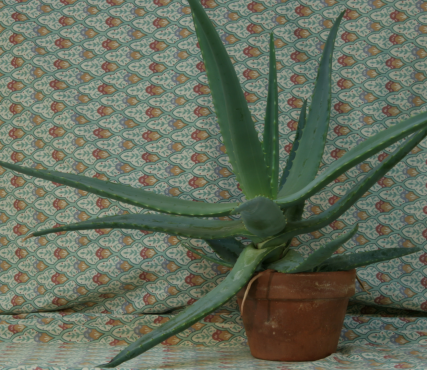

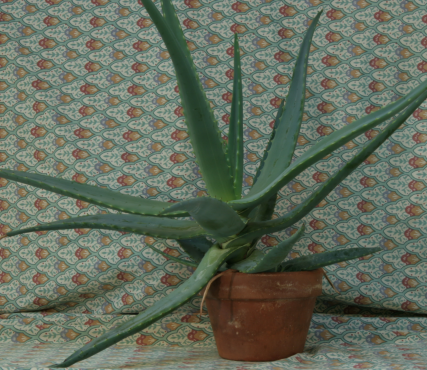

In [9]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_1.png'
disparity_range = 64
kernel_size = 3

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

#### L1 Distance

Saving result...
Done.


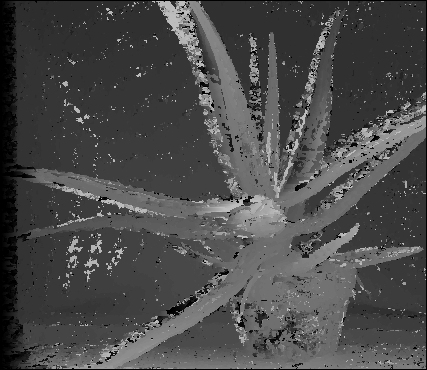

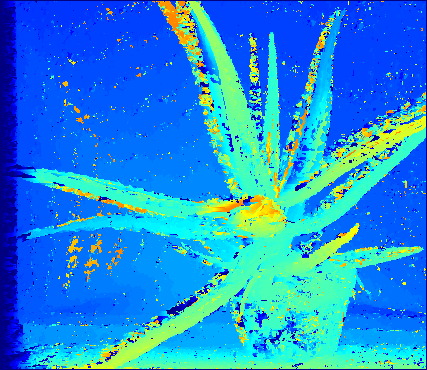

In [10]:
# L1 Result
depth = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)

cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

#### L2 Distance

Saving result...
Done.


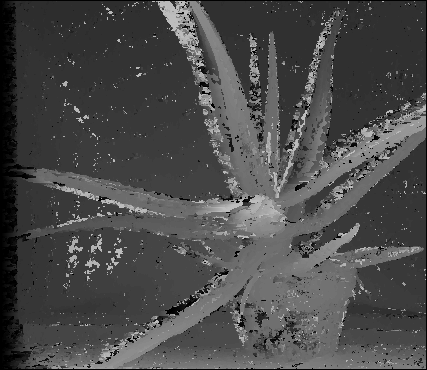

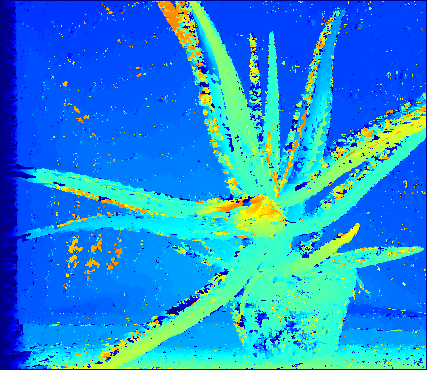

In [11]:
# L2 Result
depth = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)

cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

### **Problem 3**

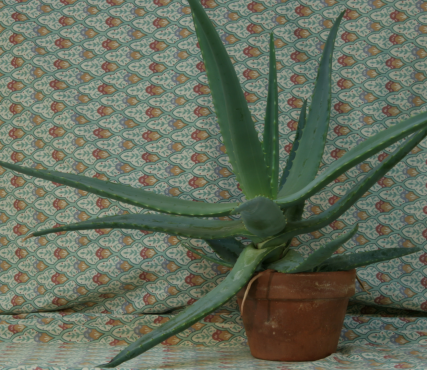

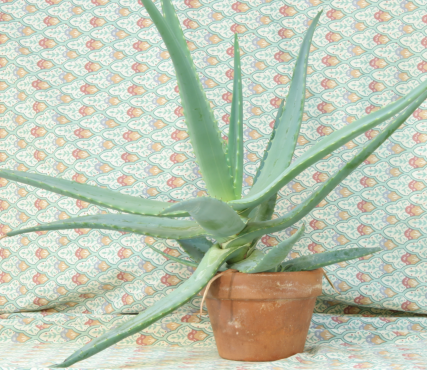

In [12]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 5

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

#### L1 Distance

Saving result...
Done.


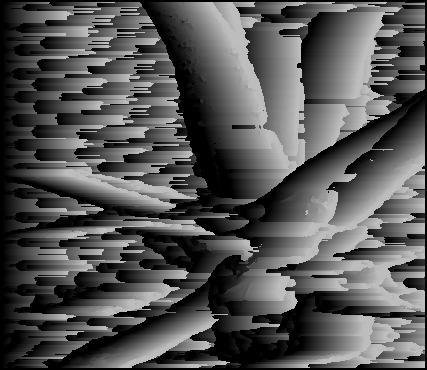

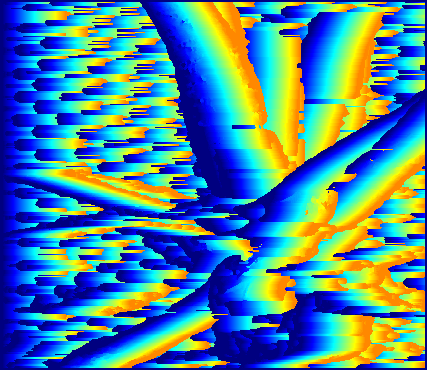

In [15]:
depth = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

#### L2 Distance

Saving result...
Done.


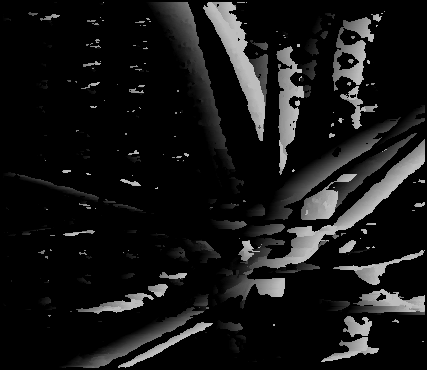

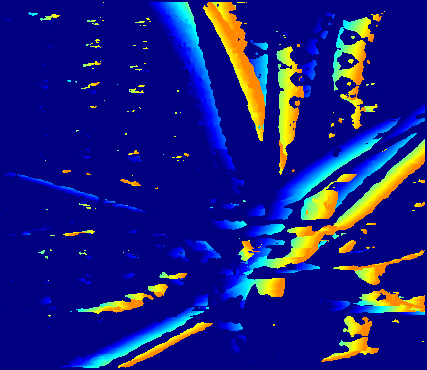

In [16]:
depth = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

### **Problem 4**

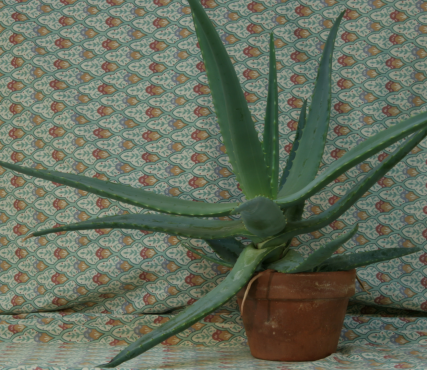

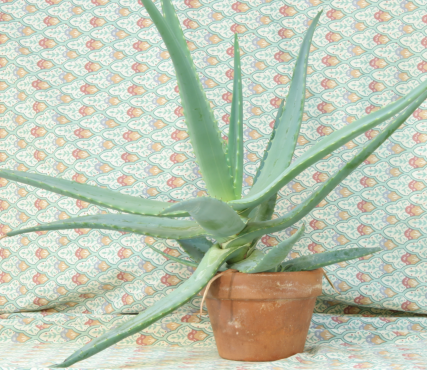

In [17]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 5

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

#### Cosine Similarity

Saving result...
Done.


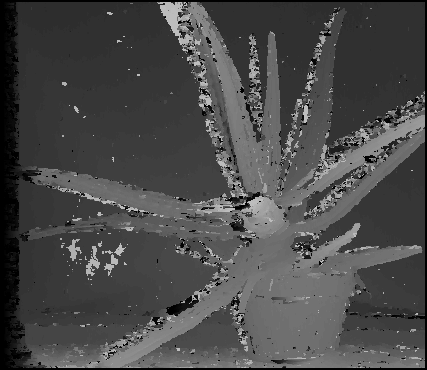

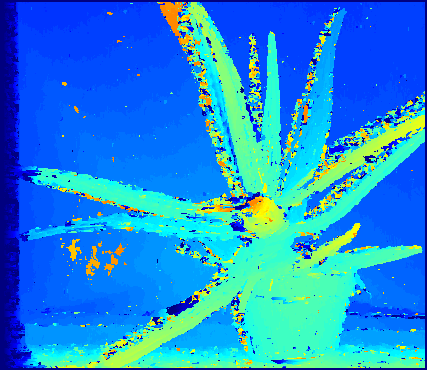

In [18]:
depth = window_based_matching_cosine_similarity(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))